In [22]:

import substation_analysis_functions
from substation_analysis_functions import *
from imp import reload
reload(substation_analysis_functions)
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import geopandas as gpd
from shapely.geometry import Point
import pyproj

from sklearn.cluster import KMeans
import math
from shapely.ops import transform
from shapely.ops import unary_union
from shapely.ops import nearest_points


Read data

In [2]:
# consumer_data = pd.read_csv('../consumer_data_counts_by_substation.csv')
# consumer_data.set_index('substation', inplace = True)
# consumer_data.index = consumer_data.index.str.lower()
# consumer_data['total_consumers'] = consumer_data.sum(axis = 1)

folder_path = "../Substation Busbar Data/"
dataframes, substation_IDs = substation_analysis_functions.read_substation_data(folder_path)
dataframes = substation_analysis_functions.handle_missing_vals(dataframes, threshold = 0.5)
for substation, dataframe in dataframes.items():
    dataframes[substation]['Date'] = dataframes[substation]['Datetime'].dt.date
    dataframes[substation]['Hour'] = dataframes[substation]['Datetime'].dt.hour
    dataframes[substation] = substation_analysis_functions.detect_bad_power_vals(dataframe,active_upper_threshold = 700, active_lower_threshold = 0, reactive_upper_threshold = 250, reactive_lower_threshold = -100) 


############  Read in raw consumer locs data ############

consumer_locs = pd.read_csv('../Dancing_types.csv')
consumer_locs['Land Uses'] = consumer_locs['LANDUSEDES']

# Define the projection of the input coordinates (OSGB36)
input_proj = pyproj.Proj(init='epsg:27700')

# Define the projection of the output coordinates (WGS84)
output_proj = pyproj.Proj(init='epsg:4326')

# Transform the coordinates
consumer_locs['Longitude'], consumer_locs['Latitude'] = pyproj.transform(input_proj, output_proj, consumer_locs['X'], consumer_locs['Y'])
consumer_locs = consumer_locs[['Longitude', 'Latitude', 'Land Uses']]

# Create a new 'geometry' column containing Point objects
geometry = [Point(xy) for xy in zip(consumer_locs['Longitude'], consumer_locs['Latitude'])]
consumer_locs = gpd.GeoDataFrame(consumer_locs, geometry=geometry, crs='EPSG:4326')




# Read in LSOA - location data
lsoa_data = gpd.read_file('lsoa_id/lsoa_data_vac1.shp')

# Read in substation - location data
substation_location_data = pd.read_csv('../substation_descriptive_data.csv')
substation_location_data['Longitude'] = -1 * substation_location_data['Longitude']



# Create a new 'geometry' column containing Point objects
geometry = [Point(xy) for xy in zip(substation_location_data['Longitude'], substation_location_data['Latitude'])]
substation_location_data = gpd.GeoDataFrame(substation_location_data, geometry=geometry, crs='EPSG:4326')


# Perform a spatial join between the two dataframes
joined_data = gpd.sjoin(substation_location_data, lsoa_data, op='within')



Substation 4626005100 Mill St flats POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4626001300 Gloucester Green POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4618007020 Hockmore Street POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4626004180 osney mead pylon  POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4614005070 queens lane telephone exchange POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4904001010 Swan mews POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4618006160 minchery farm pumping station POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 4904024005 Dan Read Parade POWER Busbar All MED AgHour FROM 2022_01_01 00_00_00 TO 2023_01_01 00_00_00.csv 

Substation 46000

/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_36051/2000889569.py:17: DtypeWarning: Columns (9,14) have mixed types. Specify dtype option on import or set low_memory=False.
  consumer_locs = pd.read_csv('../Dancing_types.csv')
/Users/Orie4416/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/Orie4416/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_

To-DO: 
1. Reassign consumers to subsattions <font color = 'orange'> In progress </font> 
2. Methodology Flow Chart
 

Filter out consumers who are outside of 500m away from any substation

In [3]:
# Define the projection to use (e.g., UTM zone)
utm_zone = "30"
project = pyproj.Transformer.from_crs("EPSG:4326", f"EPSG:326{utm_zone}")

# Project the points to the UTM zone
projected_points = substation_location_data.geometry.apply(lambda p: transform(project.transform, p))

# Calculate a buffer of 500m around each point in the projected coordinate system
substation_buffer = projected_points.buffer(500)

# Define the inverse projection to use (from UTM to WGS84)
inv_project = pyproj.Transformer.from_crs(f"EPSG:326{utm_zone}", "EPSG:4326")

# Transform the projected buffer back to EPSG:4326
buffer_latlon = substation_buffer.geometry.apply(lambda p: transform(inv_project.transform, p))

# convert substation_buffer to a GeoDataFrame with a 'geometry' column
substation_buffer_gdf = gpd.GeoDataFrame(geometry=buffer_latlon)

substation_buffer_gdf_dissolved = substation_buffer_gdf.dissolve()

# merge consumers within buffer distance of substations
consumers_within_substation_buffer = gpd.sjoin(consumer_locs, substation_buffer_gdf_dissolved, op='within')
consumers_within_substation_buffer.drop(columns = ['index_right'], inplace = True)


/var/folders/pb/drvp7crx7qn3x5331z925m1c0000gt/T/ipykernel_36051/3867504496.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  substation_buffer = projected_points.buffer(500)
/Users/Orie4416/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Plot

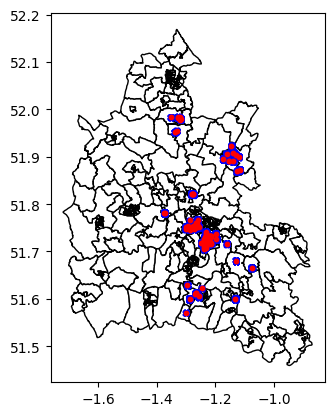

In [17]:
lsoa_data.plot(color = 'white', edgecolor = 'black')
consumers_within_substation_buffer.plot(ax = plt.gca(), marker = 'x', color = 'blue', markersize = 10)
joined_data.plot(ax = plt.gca(), marker = 'o', color = 'red', markersize = 10)

plt.show()

### Assign each consumer to a substation by finding its nearest substation

In [724]:
consumers_geodf=gpd.sjoin_nearest(consumers_within_substation_buffer, substation_location_data, how = 'inner')

# checking that the consumers ended up with the right substations
consumers_geodf.plot(column = 'Substation', markersize = 15, figsize = (10,10))
substation_location_data.plot(ax = plt.gca(), marker = 'x', color = 'black', edgecolor = 'white', markersize = 10)
plt.show()



/Users/Orie4416/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


ValueError: Got `predicate` = `nearest`, `predicate` must be one of {'contains_properly', 'covers', None, 'contains', 'within', 'touches', 'intersects', 'overlaps', 'crosses'}

In [23]:
def get_nearest_values(row, other_gdf, point_column='geometry', value_column="geometry"):
    """Find the nearest point and return the corresponding value from specified value column."""
    
    # Create an union of the other GeoDataFrame's geometries:
    other_points = other_gdf["geometry"].unary_union
    
    print('Finding nearest points')
    # Find the nearest points
    nearest_geoms = nearest_points(row[point_column], other_points)
    
    print('Getting corresponding values from other DF')
    # Get corresponding values from the other df
    nearest_data = other_gdf.loc[other_gdf["geometry"] == nearest_geoms[1]]
    
    
    
    nearest_value = nearest_data[value_column].values[0]
    print('Nearest value', nearest_value)
    
    return nearest_value

In [24]:
# convert consumers_within_substation_buffer to a GeoDataFrame with a 'geometry' column
consumers_geodf = gpd.GeoDataFrame(consumers_within_substation_buffer, geometry = consumers_within_substation_buffer.geometry, crs = 'EPSG:4326')

consumers_geodf['Substation'] = consumers_geodf.apply(get_nearest_values, other_gdf = substation_location_data, value_column = 'Substation Site', axis = 1)

# create total consumers per substation DF
total_consumers_df = consumers_geodf.groupby(['Substation']).size().reset_index(name = 'total_consumers')
total_consumers_df.set_index('Substation', inplace = True)
total_consumers_df

# create consumer breakdown per substation DF
consumer_breakdown_df  = consumers_geodf.groupby(['Substation', 'Land Uses']).size().unstack().fillna(0)
consumer_breakdown_df['total_consumers'] = consumer_breakdown_df.sum(axis = 1)
consumer_breakdown_df

Finding nearest points
Getting corresponding values from other DF
Nearest value Springfield Road
Finding nearest points
Getting corresponding values from other DF
Nearest value Springfield Road
Finding nearest points
Getting corresponding values from other DF
Nearest value medawar centre
Finding nearest points
Getting corresponding values from other DF
Nearest value medawar centre
Finding nearest points
Getting corresponding values from other DF
Nearest value brookhampton
Finding nearest points
Getting corresponding values from other DF
Nearest value Thames view Road no2
Finding nearest points
Getting corresponding values from other DF
Nearest value brookhampton
Finding nearest points
Getting corresponding values from other DF
Nearest value Chilton Garden Centre
Finding nearest points
Getting corresponding values from other DF
Nearest value Chilton Garden Centre
Finding nearest points
Getting corresponding values from other DF
Nearest value texas homecare
Finding nearest points
Getting

/Users/Orie4416/opt/anaconda3/lib/python3.9/site-packages/geopandas/plotting.py:306: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  collection = ax.scatter(x, y, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)


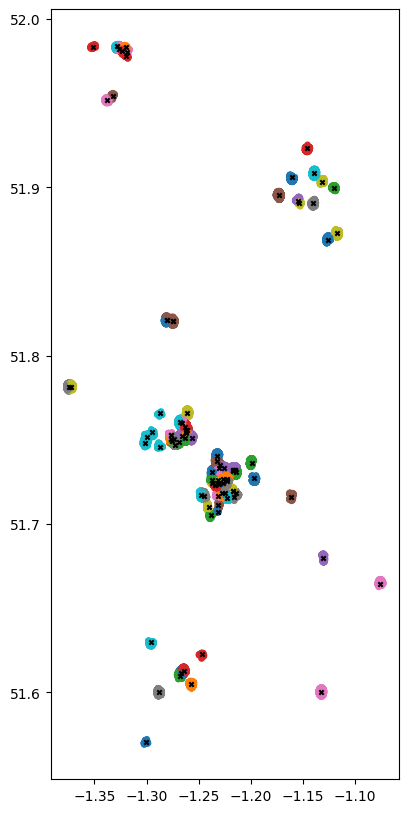

Land Uses                      Commercial  Features  Land  Mixed  \
Substation                                                         
76 Church Road                        2.0       0.0   0.0    1.0   
87 Howard Street                     20.0       1.0  25.0    1.0   
Ambrosden Park Rise                  24.0       5.0   8.0    0.0   
Barry Avenue                         15.0       0.0   3.0    0.0   
Bridge View Watlington Road          85.0       0.0  23.0    0.0   
...                                   ...       ...   ...    ...   
the perch binsey                      5.0       0.0   4.0    0.0   
units 13/14 Oxford science pk        57.0       0.0   4.0    0.0   
venables close                       73.0       1.0  50.0    4.0   
windmill st deddington                3.0       0.0   3.0    0.0   
woodcroft                             0.0       1.0   3.0    0.0   

Land Uses                      Parent Shell  Residential  Unclassified  \
Substation                                                               
76 Church Road                          2.0         62.0           0.0   
87 Howard Street                       16.0        550.0           0.0   
Ambrosden Park Rise                    15.0        260.0           0.0   
Barry Avenue                           12.0        311.0           0.0   
Bridge View Watlington Road            27.0        175.0           0.0   
...                                     ...          ...           ...   
the perch binsey                        6.0          8.0           0.0   
units 13/14 Oxford science pk          15.0        200.0           0.0   
venables close                         83.0        848.0           0.0   
windmill st deddington                  9.0        168.0           0.0   
woodcroft                               6.0        233.0           3.0   

Land Uses                      total_consumers  
Substation                                      
76 Church Road                            67.0  
87 Howard Street                         613.0  
Ambrosden Park Rise                      312.0  
Barry Avenue                             341.0  
Bridge View Watlington Road              310.0  
...                                        ...  
the perch binsey                          23.0  
units 13/14 Oxford science pk            276.0  
venables close                          1059.0  
windmill st deddington                   183.0  
woodcroft                                246.0  

[102 rows x 8 columns]

In [28]:
# checking that the consumers ended up with the right substations
consumers_geodf.plot(column = 'Substation', markersize = 15, figsize = (10,10))
substation_location_data.plot(ax = plt.gca(), marker = 'x', color = 'black', edgecolor = 'white', markersize = 10)
plt.show()

# create total consumers per substation DF
total_consumers_df = consumers_geodf.groupby(['Substation']).size().reset_index(name = 'total_consumers')
total_consumers_df.set_index('Substation', inplace = True)
total_consumers_df

# create consumer breakdown per substation DF
consumer_breakdown_df  = consumers_geodf.groupby(['Substation', 'Land Uses']).size().unstack().fillna(0)
consumer_breakdown_df['total_consumers'] = consumer_breakdown_df.sum(axis = 1)
consumer_breakdown_df

## ADMD analysis

In [26]:
# Read in LSOA - EV count data
ev_numbers_by_lsoa = pd.read_excel('EV numbers.xlsx')
#ev_numbers_by_lsoa.head(5)

# merge joined_data and ev_numbers_by_lsoa on joined_data['lsoa11cd'] and ev_numbers_by_lsoa['lsoa']
ev_count_by_substation = pd.merge(joined_data, ev_numbers_by_lsoa, left_on = 'lsoa11cd', right_on = 'lsoa')
ev_count_by_substation.set_index('Substation Number', inplace = True)
ev_count_by_substation

Substation Site Substation State   Latitude  \
Substation Number                                                            
4600007020         Bridge View Watlington Road        INSTALLED  51.727159   
4618002025          rose hill community centre        INSTALLED  51.726248   
4618003100                   Church Way Iffley        INSTALLED  51.730660   
4618003040                       henley avenue        INSTALLED  51.733260   
4618002030                 Desborough crescent        INSTALLED  51.724593   
...                                        ...              ...        ...   
4907001020                 blue boar quad RMU3        INSTALLED  51.751278   
4605005013                      chepstow drive        INSTALLED  51.895165   
4913001455               Chilton Garden Centre        INSTALLED  51.570329   
4904007140               sutton courtenay road        INSTALLED  51.629895   
4600015150                    87 Howard Street        INSTALLED  51.740465   

                   Longitude       Region Operational Area    Device Serial  \
Substation Number                                                             
4600007020         -1.196552  STH - South    RW - Ridgeway  SS7400012705221   
4618002025         -1.231316  STH - South    RW - Ridgeway  SS7400012905221   
4618003100         -1.236976  STH - South    RW - Ridgeway  SS7400007905221   
4618003040         -1.230453  STH - South    RW - Ridgeway  SS7400006205221   
4618002030         -1.232681  STH - South    RW - Ridgeway  SS7400004905221   
...                      ...          ...              ...              ...   
4907001020         -1.256715  STH - South    RW - Ridgeway  SS7400000506222   
4605005013         -1.173141  STH - South    RW - Ridgeway  SS7400016006222   
4913001455         -1.300191  STH - South    RW - Ridgeway  SS7400016706222   
4904007140         -1.295802  STH - South    RW - Ridgeway  SS7400012806222   
4600015150         -1.232063  STH - South    RW - Ridgeway  SS7400016906222   

                  Last Communication (Dublin. Edinburgh. Lisbon. London)  \
Substation Number                                                          
4600007020                                       01/03/2023 14:41:07       
4618002025                                       01/03/2023 14:41:25       
4618003100                                       01/03/2023 10:18:03       
4618003040                                       01/03/2023 14:39:00       
4618002030                                       01/03/2023 14:40:05       
...                                                              ...       
4907001020                                       01/03/2023 14:41:24       
4605005013                                       01/03/2023 14:42:00       
4913001455                                       01/03/2023 14:41:36       
4904007140                                       01/03/2023 14:42:00       
4600015150                                       01/03/2023 14:41:00       

                                                               Modes  \
Substation Number                                                      
4600007020         NORMAL. NETWORK_POWER_QUALITY. CURRENT_HARMONI...   
4618002025         NORMAL. NETWORK_POWER_QUALITY. CURRENT_HARMONI...   
4618003100         NORMAL. NETWORK_POWER_QUALITY. CURRENT_HARMONI...   
4618003040         NORMAL. NETWORK_POWER_QUALITY. CURRENT_HARMONI...   
4618002030         NORMAL. NETWORK_POWER_QUALITY. CURRENT_HARMONI...   
...                                                              ...   
4907001020         NORMAL. NETWORK_POWER_QUALITY. CURRENT_HARMONI...   
4605005013         NORMAL. NETWORK_POWER_QUALITY. CURRENT_HARMONI...   
4913001455         NORMAL. NETWORK_POWER_QUALITY. CURRENT_HARMONI...   
4904007140         NORMAL. NETWORK_POWER_QUALITY. CURRENT_HARMONI...   
4600015150         NORMAL. NETWORK_POWER_QUALITY. CURRENT_HARMONI...   

                                    geometry  ...    pv_annual

Monthly ADMD

In [ ]:
####### MONTHLY ADMD #######

###### Get substation monthly active power ######
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
days_in_month_df = pd.DataFrame(columns = ['Month', 'total_available_monthly_hours'])
days_in_month_df['Month'] = np.arange(1,13)
days_in_month_df['total_available_monthly_hours'] = [24 * days for days in days_in_month]

# Get total Active Power for each substation for each month (.groupby('Month').sum('Active Power [kW]'))
substation_monthly_active_powers = pd.DataFrame(index = dataframes.keys(), columns = np.arange(1,13))
for substation in dataframes:
    print(substation)
    # Add month column to dataframe
    dataframes[substation]['Month'] = dataframes[substation]['Datetime'].dt.month
    
    # Group data by month
    grouped_data = dataframes[substation].groupby('Month')
    
    ### Get total Active Power for each substation for each month
    monthly_powers = grouped_data['Active Power [kW]'].max() 
    
    # Create a new dataframe with the monthly active power data and the number of hours of data for each month
    monthly_powers_and_hour_count = pd.concat([monthly_powers, grouped_data.count()['Hour']], axis = 1)
    
    # identify the total number of hours that should appear in each month that this substation has data on if the data was perfectly complete
    monthly_powers_and_hour_count = pd.merge(monthly_powers_and_hour_count, days_in_month_df, on = 'Month')
    monthly_powers_and_hour_count.set_index('Month', inplace = True)

    # Replace monthly active power values with nan's for months that are missing at least two days of data
    monthly_powers_and_hour_count['Active Power [kW]'] = np.where(monthly_powers_and_hour_count['Hour'] > monthly_powers_and_hour_count['total_available_monthly_hours'] - 48, grouped_data.max()['Active Power [kW]'], np.nan)
   
    # Create a new array of length 12 filled with nan's to host the monthly active power data
    monthly_active_power_clean = np.full((1, 12), np.nan)
    
    # Replace nan's with the monthly active power data corresponding to the months with data
    months_with_data = monthly_powers_and_hour_count.index.values
    
    monthly_active_power_clean[:, months_with_data-1] = monthly_powers_and_hour_count['Active Power [kW]'].values.reshape(1, -1)
       
    
    # Add monthly_powers to substation_monthly_active_powers dataframe
    substation_monthly_active_powers.loc[substation] = monthly_active_power_clean
  
  
  
  ####  ####  ####  ####  ####  ####  ####  ####  ####  ####

# Merge substation_monthly_active_powers with substation_IDs to get numbers for each substation
substation_monthly_active_powers_with_ID = pd.merge(substation_monthly_active_powers, substation_IDs, left_index = True, right_on = 'Substation').set_index("ID")

# Merge substation_monthly_active_powers with ev_count_by_substation to get numbers for each substation, merge on the indeces for the two dataframes
substation_monthly_active_powers_and_ev_counts = pd.merge(substation_monthly_active_powers_with_ID, ev_count_by_substation, left_index = True, right_index = True)

substation_monthly_active_powers_and_ev_counts.drop_duplicates(inplace = True, keep = 'first')



# Take those columns out and put them in the final dataframe for calculating ADMD
admd_df = pd.concat([substation_monthly_active_powers_and_ev_counts.iloc[:,0:13], substation_monthly_active_powers_and_ev_counts[['lsoa', 'Substation Site', '2025']]], axis = 1)
admd_df.set_index('Substation Site', inplace = True)

# Add the consumer count for each substation by joining admd_df and consumer_data on admd_df.index and consumer_data.index
admd_df = pd.merge(admd_df, consumer_data, left_index = True, right_index = True)

# Drop duplicated indeces
admd_df = admd_df[~admd_df.index.duplicated(keep='first')]

# Create a column that identifies how many times the LSOA in that row appears in the dataframe
admd_df['lsoa_count'] = admd_df.groupby('lsoa')['lsoa'].transform('count')

# Create a column that identifies how many consumers are in each LSOA
admd_df['consumers_wihin_lsoa'] = admd_df.groupby('lsoa')['total_consumers'].transform('sum')

# Create a column that identifies the proportion of consumers each substation has in its LSOA
admd_df['substation_population_weight_within_lsoa'] = admd_df['total_consumers'] / admd_df['consumers_wihin_lsoa']

# Split EVs among substations for the LSOA with multiple substations
admd_df['ev_count'] = admd_df['2025'] * admd_df['substation_population_weight_within_lsoa']

# divide the monthly active power sum columns (columns 1 thru 12) by the column 'total_consumers' to get the ADMD for each month for each substation
admd_df.iloc[:,0:12] = admd_df.iloc[:,0:12].div(admd_df['total_consumers'], axis = 0)
admd = pd.concat([admd_df.iloc[:,0:12], admd_df['ev_count']], axis = 1)
print(len(admd), "substations made it all the way through to the final dataset")


# Plotting: Compare ADMD in months 1 through 12 with ev_count (each color is a month)
for i in range(1,13):
    plt.scatter(y = admd[i], x = admd['ev_count'])
plt.ylabel('ADMD (max of monthly active power / total consumers)')
plt.xlabel('EV Count (num EVs in LSOA / num substations in LSOA)')

plt.show()

Yearly ADMD

In [27]:
####### YEARLY ADMD #######
# Get total Active Power for each substation for each month (.groupby('Month').sum('Active Power [kW]'))
substation_yearly_max_power = pd.DataFrame(index = dataframes.keys(), columns = ['Maximum Active Power [kW]'])
for substation in dataframes:
    max_power = dataframes[substation]['Active Power [kW]'].max()
   # print(max_power)
     # Add monthly_powers to substation_monthly_active_powers dataframe
    substation_yearly_max_power.loc[substation] = max_power
   
substation_yearly_max_power_with_ID = pd.merge(substation_yearly_max_power, substation_IDs, left_index = True, right_on = 'Substation').set_index("ID")

# Merge substation_monthly_active_powers with ev_count_by_substation to get numbers for each substation, merge on the indeces for the two dataframes
substation_yearly_max_powers_and_ev_counts = pd.merge(substation_yearly_max_power_with_ID, ev_count_by_substation, left_index = True, right_index = True)
#print(len(substation_monthly_active_powers_and_ev_counts))
substation_yearly_max_powers_and_ev_counts = substation_yearly_max_powers_and_ev_counts[~substation_yearly_max_powers_and_ev_counts['Substation'].duplicated(keep = 'first')]

# Take those columns out and put them in the final dataframe for calculating ADMD
yearly_admd_df = pd.concat([substation_yearly_max_powers_and_ev_counts.iloc[:,0:13], substation_yearly_max_powers_and_ev_counts[['lsoa', 'Substation Site', '2025']]], axis = 1)
yearly_admd_df.set_index('Substation', inplace = True)

# Convert indexes to lower case for merge so that more substations mach
yearly_admd_df.index = yearly_admd_df.index.str.lower()
consumer_breakdown_df.index = consumer_breakdown_df.index.str.lower()

# Add the consumer count for each substation by joining admd_df and consumer_data on admd_df.index and consumer_data.index
yearly_admd_df_with_consumer_counts = pd.merge(yearly_admd_df, consumer_breakdown_df, left_index = True, right_index = True)

# Drop duplicated indeces
yearly_admd_df_with_consumer_counts = yearly_admd_df_with_consumer_counts[~yearly_admd_df_with_consumer_counts.index.duplicated(keep = 'first')]

# Create a column that identifies how many times the LSOA in that row appears in the dataframe
yearly_admd_df_with_consumer_counts['lsoa_count'] = yearly_admd_df_with_consumer_counts.groupby('lsoa')['lsoa'].transform('count')

# Create a column that identifies how many consumers are in each LSOA
yearly_admd_df_with_consumer_counts['consumers_wihin_lsoa'] = yearly_admd_df_with_consumer_counts.groupby('lsoa')['total_consumers'].transform('sum')

# Create a column that identifies the proportion of consumers each substation has in its LSOA
yearly_admd_df_with_consumer_counts['substation_population_weight_within_lsoa'] = yearly_admd_df_with_consumer_counts['total_consumers'] / yearly_admd_df_with_consumer_counts['consumers_wihin_lsoa']

# Split EVs among substations for the LSOA with multiple substations
yearly_admd_df_with_consumer_counts['ev_count'] = yearly_admd_df_with_consumer_counts['2025'] * yearly_admd_df_with_consumer_counts['substation_population_weight_within_lsoa']

# divide the monthly active power sum columns (columns 1 thru 12) by the column 'total_consumers' to get the ADMD for each month for each substation
yearly_admd_df_with_consumer_counts['Yearly_ADMD'] = yearly_admd_df_with_consumer_counts['Maximum Active Power [kW]'] / yearly_admd_df_with_consumer_counts['total_consumers']

# add propresidential and propcommercial columns
yearly_admd_df_with_consumer_counts['res_pct'] = yearly_admd_df_with_consumer_counts['Residential'] / yearly_admd_df_with_consumer_counts['total_consumers']
yearly_admd_df_with_consumer_counts['comm_pct'] = yearly_admd_df_with_consumer_counts['Commercial'] / yearly_admd_df_with_consumer_counts['total_consumers']

### Plotting

Plotting ADMD against EV Count, coloring by residential and commercial percentage clusters 

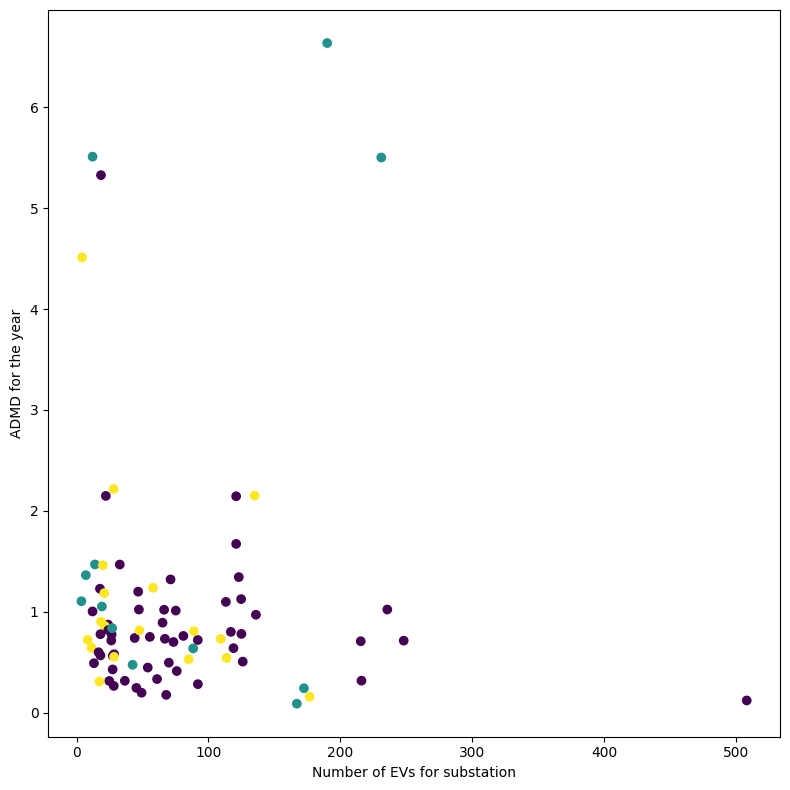

In [703]:
X = yearly_admd_df_with_consumer_counts[['res_pct','comm_pct']].values
kmeans = KMeans(n_clusters = 3, random_state = 0)
kmeans.fit(X)

yearly_admd_df_with_consumer_counts['cluster'] = kmeans.labels_

yearly_admd_df_with_consumer_counts

plt.rcParams["figure.figsize"] = (8,8)

plt.scatter(yearly_admd_df_with_consumer_counts['ev_count'], yearly_admd_df_with_consumer_counts['Yearly_ADMD'], c= yearly_admd_df_with_consumer_counts['cluster'])
# text label next to each point on the graph with its values in res_pct and comm_pct
# text = [plt.text(yearly_admd_df_with_consumer_counts['ev_count'][i]-2, yearly_admd_df_with_consumer_counts['Yearly_ADMD'][i] +0.05, str("{:.1f}".format(100 * yearly_admd_df_with_consumer_counts['res_pct'][i])[:2]) + "%", fontsize = 6, color = 'red') for i in range(len(yearly_admd_df_with_consumer_counts))]
# text = [plt.text(yearly_admd_df_with_consumer_counts['ev_count'][i] -2, yearly_admd_df_with_consumer_counts['Yearly_ADMD'][i] - 0.1, str("{:.1f}".format(100 * yearly_admd_df_with_consumer_counts['comm_pct'][i])[:2]) + "%", fontsize = 6, color = 'black') for i in range(len(yearly_admd_df_with_consumer_counts))]

plt.xlabel("Number of EVs for substation")
plt.ylabel("ADMD for the year")    
plt.tight_layout()
plt.savefig("../figures/res_and_comm_pct_on_admd_plot_cluster_labels.png")
plt.show()

Plotting all land type percentages separately (1 separate graph for each type)

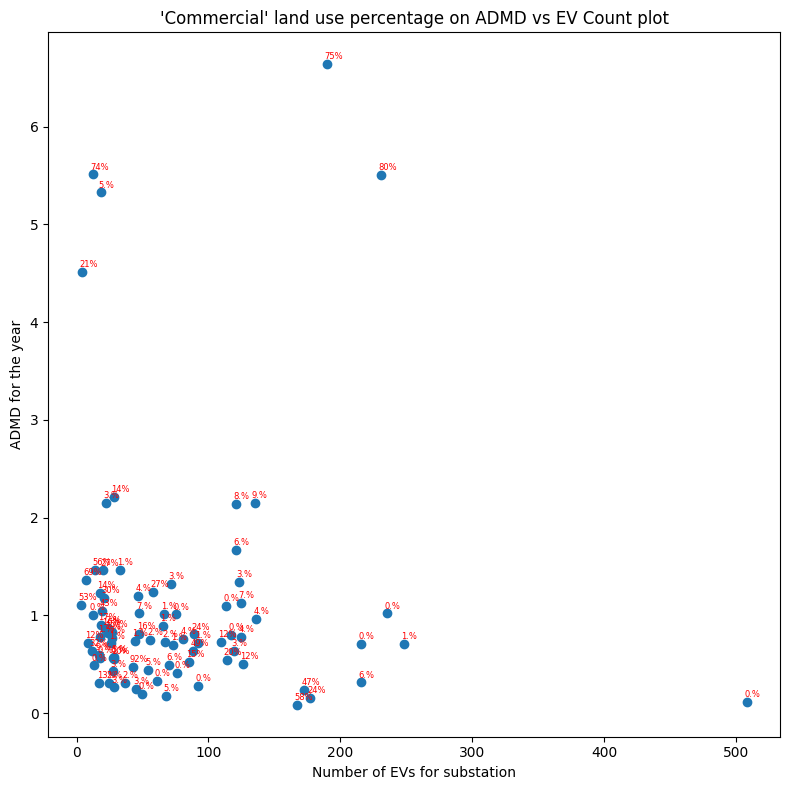

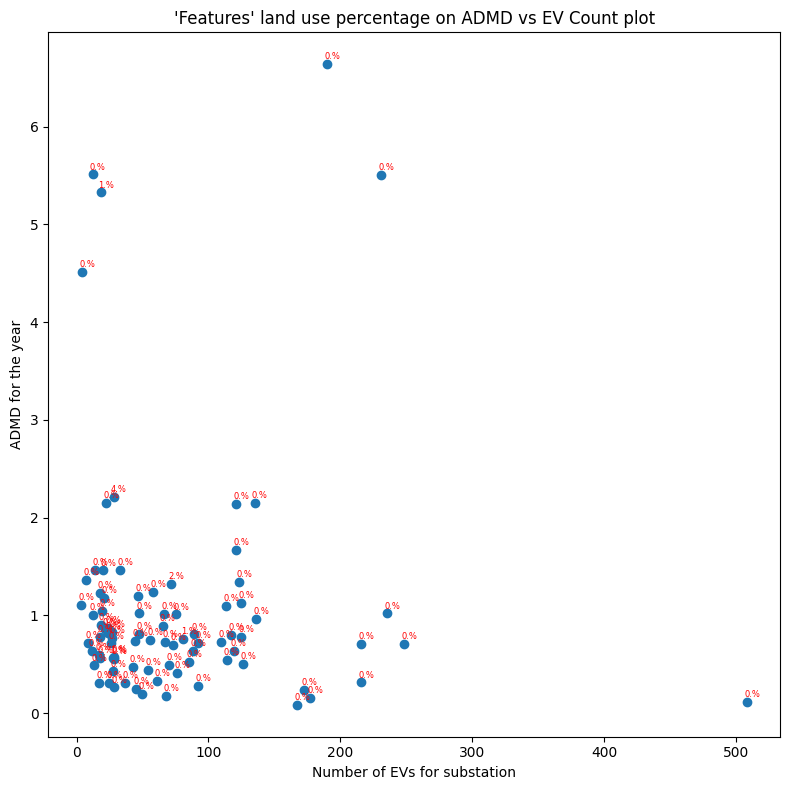

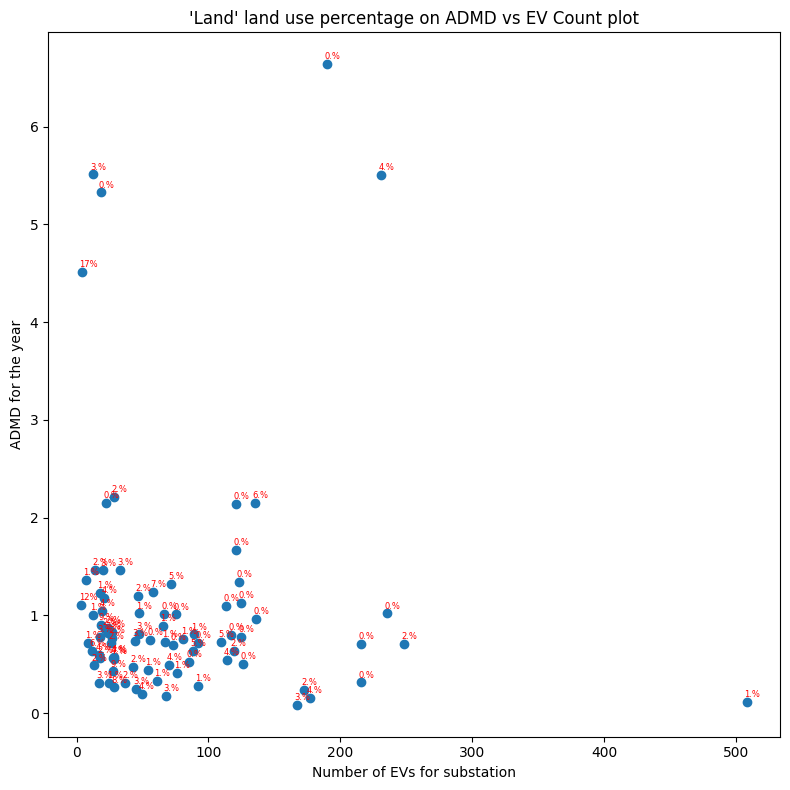

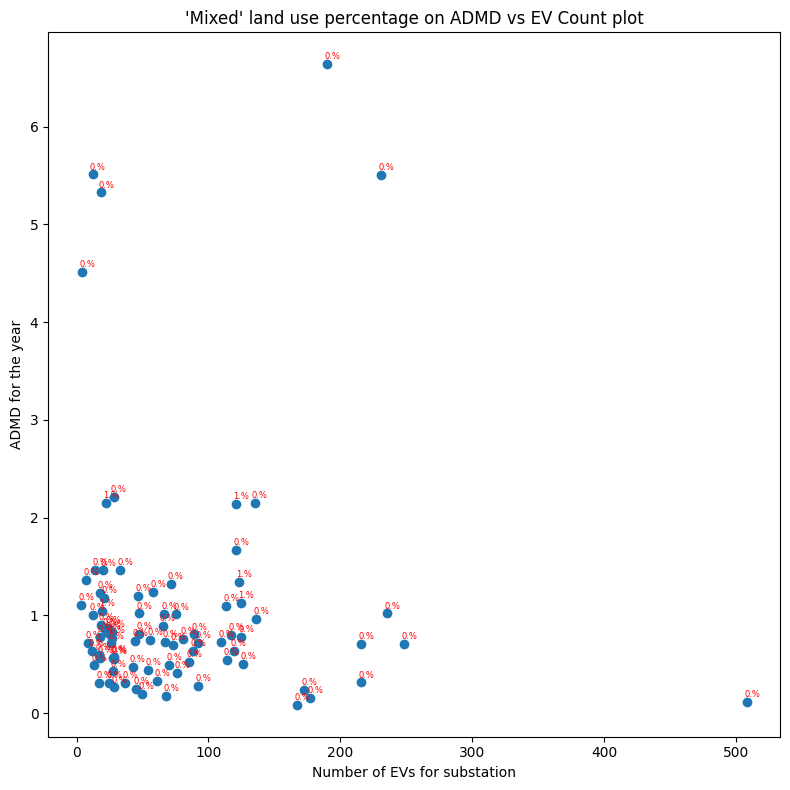

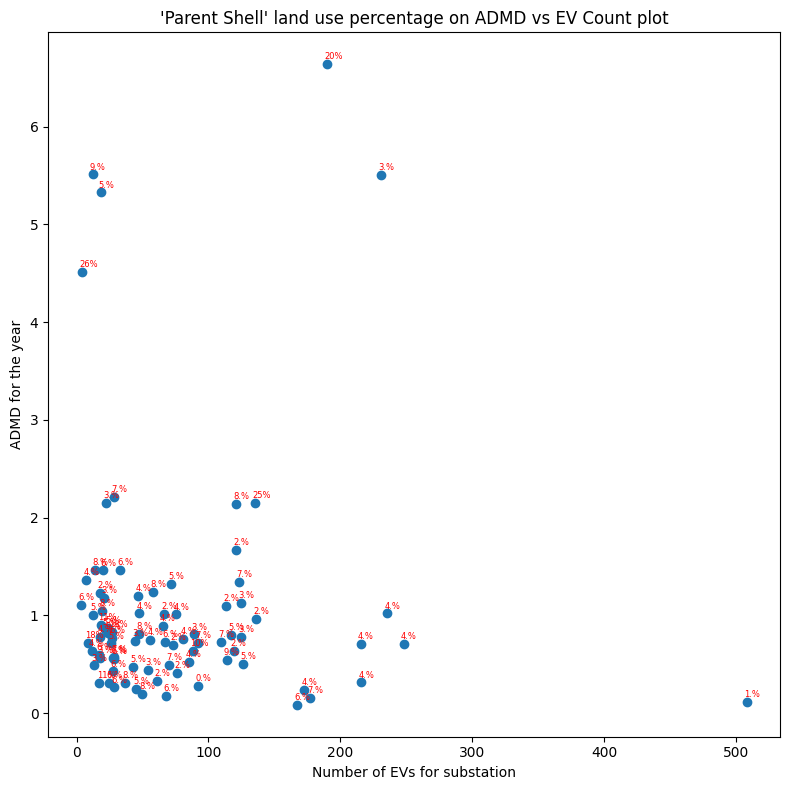

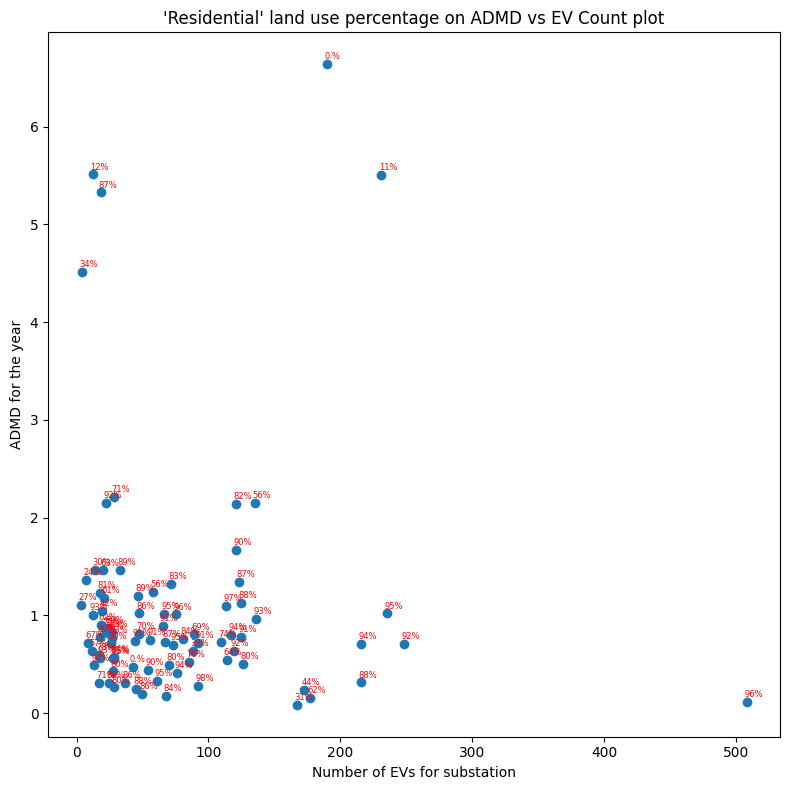

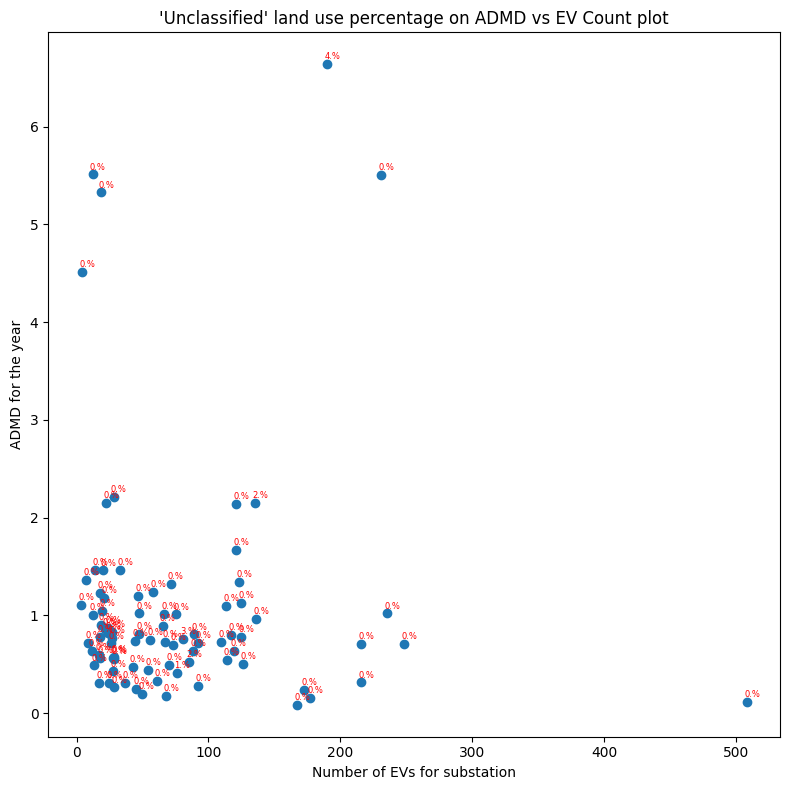

In [46]:
# Create consumer type percentage columns in yearly_admd_df_with_consumer_counts

for consumer_type in consumer_breakdown_df.iloc[:,:-1].columns.values:
    yearly_admd_df_with_consumer_counts[f'{consumer_type}_pct'] = yearly_admd_df_with_consumer_counts[consumer_type] / yearly_admd_df_with_consumer_counts['total_consumers']
    
for consumer_type in consumer_breakdown_df.iloc[:,:-1].columns.values:
    plt.rcParams["figure.figsize"] = (8,8)

    plt.scatter(yearly_admd_df_with_consumer_counts['ev_count'], yearly_admd_df_with_consumer_counts['Yearly_ADMD'])

    text = [plt.text(yearly_admd_df_with_consumer_counts['ev_count'][i]-2, yearly_admd_df_with_consumer_counts['Yearly_ADMD'][i] +0.05, str("{:.1f}".format(100 * yearly_admd_df_with_consumer_counts[f'{consumer_type}_pct'][i])[:2]) + "%", fontsize = 6, color = 'red') for i in range(len(yearly_admd_df_with_consumer_counts))]

    plt.title(f"\'{consumer_type}\' land use percentage on ADMD vs EV Count plot")
    plt.xlabel("Number of EVs for substation")
    plt.ylabel("ADMD for the year")    
    plt.tight_layout()
    plt.savefig(f"figures/{consumer_type}_pct_on_admd_plot.png")
    plt.show()